In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

In [2]:
import keras
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image

Using TensorFlow backend.


In [3]:
keras.__version__

'2.0.8'

In [4]:
tf.__version__

'1.3.0'

### Hyperparameters

In [5]:
DATA_FILE_PATH = 'data/quora_duplicate_questions.tsv' 
EMB_DIR = '/collection/hpallika/deeplearning/research_work/word_embeddings/glove.6B.50d.txt'

MAX_VOCAB_SIZE = 30000
MAX_SENT_LEN = 15
EMBEDDING_DIM = 50
BATCH_SIZE = 32
N_EPOCHS = 10

In [6]:
df_questions = pd.read_table(DATA_FILE_PATH, sep='\t', nrows=100000)
print('Dataset size:', df_questions.shape)
df_questions.head(3)

Dataset size: (100000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [7]:
# Converting all questions to string
df_questions['question1'] = df_questions['question1'].apply(lambda x: str(x))
df_questions['question2'] = df_questions['question2'].apply(lambda x: str(x))

In [8]:
sent_len = lambda x:len(x)
df_questions['q1_length'] = df_questions.question1.apply(sent_len)
df_questions['q2_length'] = df_questions.question2.apply(sent_len)
df_questions[df_questions['q1_length']<10]['question1'].head(10)

3305             .
13016            ?
20797            ?
23888           HH
25233        What?
25320      deleted
54040         I'm 
57496      grammar
63292    How long?
63726        What?
Name: question1, dtype: object

In [9]:
# Questions having lesser than 10 characters can be discarded. 
indices = set(df_questions[df_questions['q1_length']<10].index).union(df_questions[df_questions['q2_length']<10].index)

# Can drop the character count columns - to save memory
df_questions.drop(['q1_length','q2_length'], inplace=True, axis=1)

df_questions.drop(indices, inplace=True)
df_questions.reset_index()

df_questions.is_duplicate.value_counts()

0    62718
1    37260
Name: is_duplicate, dtype: int64

In [10]:
word_count = lambda x:len(x.split()) # Word count for each question
df_questions['q1_wc'] = df_questions.question1.apply(word_count)
df_questions['q2_wc'] = df_questions.question2.apply(word_count)

p = 80.0

print('Question-1 :{} % of the sentences have a length less than or equal to {}'.format(p, np.percentile(df_questions['q1_wc'], 80)))
print('Question-2 :{} % of the sentences have a length less than or equal to {}'.format(p, np.percentile(df_questions['q2_wc'], 80)))

Question-1 :80.0 % of the sentences have a length less than or equal to 14.0
Question-2 :80.0 % of the sentences have a length less than or equal to 14.0


Better to use NLTK tokenizer first and then Keras word to indices <br>
Keras: 'what is this?' -> ['what', 'is', 'this?']

In [11]:
%%time
question_list = list(df_questions['question1']) + list(df_questions['question2'])
question_list = [' '.join(word_tokenize(q)[:MAX_SENT_LEN]) for q in question_list]

CPU times: user 22.6 s, sys: 236 ms, total: 22.9 s
Wall time: 22.5 s


In [12]:
question_list[:10] # Data is noisy with many unwanted characters

['What is the step by step guide to invest in share market in india ?',
 'What is the story of Kohinoor ( Koh-i-Noor ) Diamond ?',
 'How can I increase the speed of my internet connection while using a VPN ?',
 'Why am I mentally very lonely ? How can I solve it ?',
 'Which one dissolve in water quikly sugar , salt , methane and carbon di oxide',
 'Astrology : I am a Capricorn Sun Cap moon and cap rising ... what does',
 'Should I buy tiago ?',
 'How can I be a good geologist ?',
 'When do you use シ instead of し ?',
 'Motorola ( company ) : Can I hack my Charter Motorolla DCX3400 ?']

In [13]:
# Filters - removed '?' 
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n') 
tokenizer.fit_on_texts(question_list)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 43965


In [14]:
# Limit vocab and idx-word dictionary
word_index =  word_index = {k: v for k, v in tokenizer.word_index.items() if v < MAX_VOCAB_SIZE}
idx_to_word = dict((v,k) for k,v in word_index.items())

In [15]:
X = tokenizer.texts_to_sequences(question_list)
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

X_q1 = X[:len(X)//2]
X_q2 = X[len(X)//2:]
del X

X_q1[:3]

array([[    3,     4,     2,  1408,    62,  1408,  3321,     8,   578,
            9,   767,   399,     9,    37,     1],
       [    3,     4,     2,   647,    11, 11651, 12828,     6, 16482,
         4236,     1,     0,     0,     0,     0],
       [    5,    14,     6,   198,     2,   476,    11,    19,   357,
         2234,   219,   146,     7,  2796,     1]], dtype=int32)

In [16]:
X_train_q1, X_test_q1, X_train_q2, X_test_q2, y_train, y_test = train_test_split(X_q1,
                                                                                 X_q2,
                                                                                 df_questions['is_duplicate'],
                                                                                 random_state=10, 
                                                                                 test_size=0.1)

### Embedding Matrix

In [17]:
# Load GloVe word embeddings 
# Download Link: https://nlp.stanford.edu/projects/glove/
print("[INFO]: Reading Word Embeddings ...")
# Data path
embeddings = {}
f = open(EMB_DIR)
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

[INFO]: Reading Word Embeddings ...


In [18]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

### CNN with Keras Model API
Also called Graph/Functional API

In [19]:
from keras.models import Model
from keras.layers import Layer, Input, Dense, Concatenate, Conv2D, Reshape, MaxPooling1D, Flatten, BatchNormalization, Activation, Dropout, Embedding

In [20]:
# Bigram and trigram filters
bi_filter_size = 2
tri_filter_size = 3

num_filters = 20

#### Question 1 Computational Graph

In [21]:
input_1 = Input(shape=(MAX_SENT_LEN, ), name='q1_input')

# Common embedding lookup layer
emb_look_up = Embedding(input_dim=MAX_VOCAB_SIZE,
                        output_dim=EMBEDDING_DIM,
                        weights = [embeddings_matrix], 
                        trainable=False, 
                        mask_zero=False,
                        name='q_embedding_lookup')

emb_1 = emb_look_up(input_1)

# Need to be reshaped because the CONV layer assumes 1 dimnesion as num of channels
emb_1 = Reshape(target_shape=(1, MAX_SENT_LEN, EMBEDDING_DIM), 
                name='q1_embedding_reshape')(emb_1) 

# Convolutional Layers
conv_1_bi =  Conv2D(filters=num_filters, 
                    kernel_size=(bi_filter_size, EMBEDDING_DIM), 
                    padding='valid', 
                    activation='relu', 
                    data_format='channels_first', 
                    name='q1_bigram_conv')(emb_1)

conv_1_tri =  Conv2D(filters=num_filters, 
                     kernel_size=(tri_filter_size, EMBEDDING_DIM), 
                     padding='valid', 
                     activation='relu', 
                     data_format='channels_first', 
                     name='q1_trigram_conv')(emb_1)

# Remove channel dimension before max-pooling operation
bi_out_timesteps = MAX_SENT_LEN - bi_filter_size + 1
tri_out_timesteps = MAX_SENT_LEN - tri_filter_size + 1

conv_1_bi = Reshape(target_shape=(bi_out_timesteps, num_filters), 
                    name='q1_bigram_conv_reshape')(conv_1_bi) # (MAX_SENT_LEN - bi_filter_size + 1, num_filters)
conv_1_tri = Reshape(target_shape=(tri_out_timesteps, num_filters), 
                     name='q1_trigram_conv_reshape')(conv_1_tri)

# Max-pooling Layer
# Pool across timesteps to get 1 feature per filter, i.e., each filter captures 1 feature about the sentence/question
max_pool_1_bi = MaxPooling1D(pool_size = bi_out_timesteps, 
                             name='q1_bigram_maxpool')(conv_1_bi)
max_pool_1_tri = MaxPooling1D(pool_size = tri_out_timesteps, 
                              name='q1_trigram_maxpool')(conv_1_tri)

# Merge the features learnt by bi and tri filters
merged_1 = Concatenate(name='q1_maxpool_concat')([max_pool_1_bi, max_pool_1_tri])
# Inputs dropped out randomly so that there is no heavy dependence on specific features for prediction
dropout_1 = Dropout(rate=0.2, 
                    name='q1_dropout')(merged_1)
flatten_1 = Flatten(name='q1_flatten')(dropout_1)

#### Question 2 Computational Graph

In [22]:
input_2 = Input(shape=(MAX_SENT_LEN, ), name='q2_input')

emb_2 = emb_look_up(input_2)

# Need to be reshaped because the CONV layer assumes 1 dimnesion as num of channels
emb_2 = Reshape((1, MAX_SENT_LEN, EMBEDDING_DIM), 
                name='q2_embedding_reshape')(emb_2)

# Convolutional Layers
conv_2_bi =  Conv2D(filters=num_filters, 
                    kernel_size=(bi_filter_size, EMBEDDING_DIM), 
                    padding='valid', 
                    activation='relu', 
                    data_format='channels_first', 
                    name='q2_bigram_conv')(emb_2)

conv_2_tri =  Conv2D(filters=num_filters, 
                     kernel_size=(tri_filter_size, EMBEDDING_DIM), 
                     padding='valid', 
                     activation='relu', 
                     data_format='channels_first', 
                     name='q2_trigram_conv')(emb_2)

# Remove channel dimension before max-pooling operation
conv_2_bi = Reshape((bi_out_timesteps, num_filters), 
                    name='q2_bigram_conv_reshape')(conv_2_bi) # (MAX_SENT_LEN - bi_filter_size + 1, num_filters)
conv_2_tri = Reshape((tri_out_timesteps, num_filters), 
                     name='q2_trigram_conv_reshape')(conv_2_tri)

# Max-pooling Layer
# Pool across timesteps to get 1 feature per filter, i.e., each filter captures 1 feature about the sentence/question
max_pool_2_bi = MaxPooling1D(pool_size = bi_out_timesteps, 
                             name='q2_bigram_maxpool')(conv_2_bi)
max_pool_2_tri = MaxPooling1D(pool_size = tri_out_timesteps, 
                              name='q2_trigram_maxpool')(conv_2_tri)

# Merge the features learnt by bi and tri filters
merged_2 = Concatenate(name='q2_maxpool_flatten')([max_pool_2_bi, max_pool_2_tri])
# Inputs dropped out randomly so that there is no heavy dependence on specific features for prediction
dropout_2 = Dropout(rate=0.2, 
                    name='q2_dropout')(merged_2)
flatten_2 = Flatten(name='q2_flatten')(dropout_2)

#### Merge outputs of Q1 and Q2

In [23]:
# With batch-normalization, the output of a previous layer is mu-sigma normalized, 
# before it is fed into the next layer. 
# For feed-forward networks, batch-normalization is carried out 
# after/before applying RELU activation (?)
# https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/

merged = Concatenate(name='q1_q2_concat')([flatten_1, flatten_2])

# Dense layers
dense_1 = Dense(units=10, 
                name='q1_q2_dense')(merged)
bn_1 = BatchNormalization(name='batchnorm')(dense_1)
relu_1 = Activation(activation='relu', 
                    name='relu_activation')(bn_1)
dense_1_dropout = Dropout(0.2, 
                          name='dense_dropout')(relu_1)

output_prob = Dense(units=1, 
                    activation='sigmoid', 
                    name='output_layer')(dense_1_dropout)

model = Model(inputs=[input_1, input_2], outputs=output_prob, name='text_pair_cnn')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
q1_input (InputLayer)            (None, 15)            0                                            
____________________________________________________________________________________________________
q2_input (InputLayer)            (None, 15)            0                                            
____________________________________________________________________________________________________
q_embedding_lookup (Embedding)   (None, 15, 50)        1500000     q1_input[0][0]                   
                                                                   q2_input[0][0]                   
____________________________________________________________________________________________________
q1_embedding_reshape (Reshape)   (None, 1, 15, 50)     0           q_embedding_lookup[0][0]

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x = [X_train_q1, X_train_q2], 
          y = y_train, 
          batch_size=BATCH_SIZE, 
          epochs=N_EPOCHS, 
          validation_data=([X_test_q1, X_test_q2], y_test))

Train on 89980 samples, validate on 9998 samples
Epoch 1/10
89980/89980 [==============================] - 29s - loss: 0.6386 - acc: 0.6452 - val_loss: 0.5895 - val_acc: 0.6957
Epoch 2/10
89980/89980 [==============================] - 28s - loss: 0.5878 - acc: 0.6930 - val_loss: 0.5701 - val_acc: 0.7083
Epoch 3/10
89980/89980 [==============================] - 28s - loss: 0.5722 - acc: 0.7063 - val_loss: 0.5586 - val_acc: 0.7103
Epoch 4/10
89980/89980 [==============================] - 28s - loss: 0.5617 - acc: 0.7160 - val_loss: 0.5531 - val_acc: 0.7214
Epoch 5/10
89980/89980 [==============================] - 28s - loss: 0.5537 - acc: 0.7208 - val_loss: 0.5487 - val_acc: 0.7207
Epoch 6/10
89980/89980 [==============================] - 28s - loss: 0.5464 - acc: 0.7247 - val_loss: 0.5458 - val_acc: 0.7257
Epoch 7/10
89980/89980 [==============================] - 28s - loss: 0.5409 - acc: 0.7300 - val_loss: 0.5422 - val_acc: 0.7256
Epoch 8/10
89980/89980 [==============================]

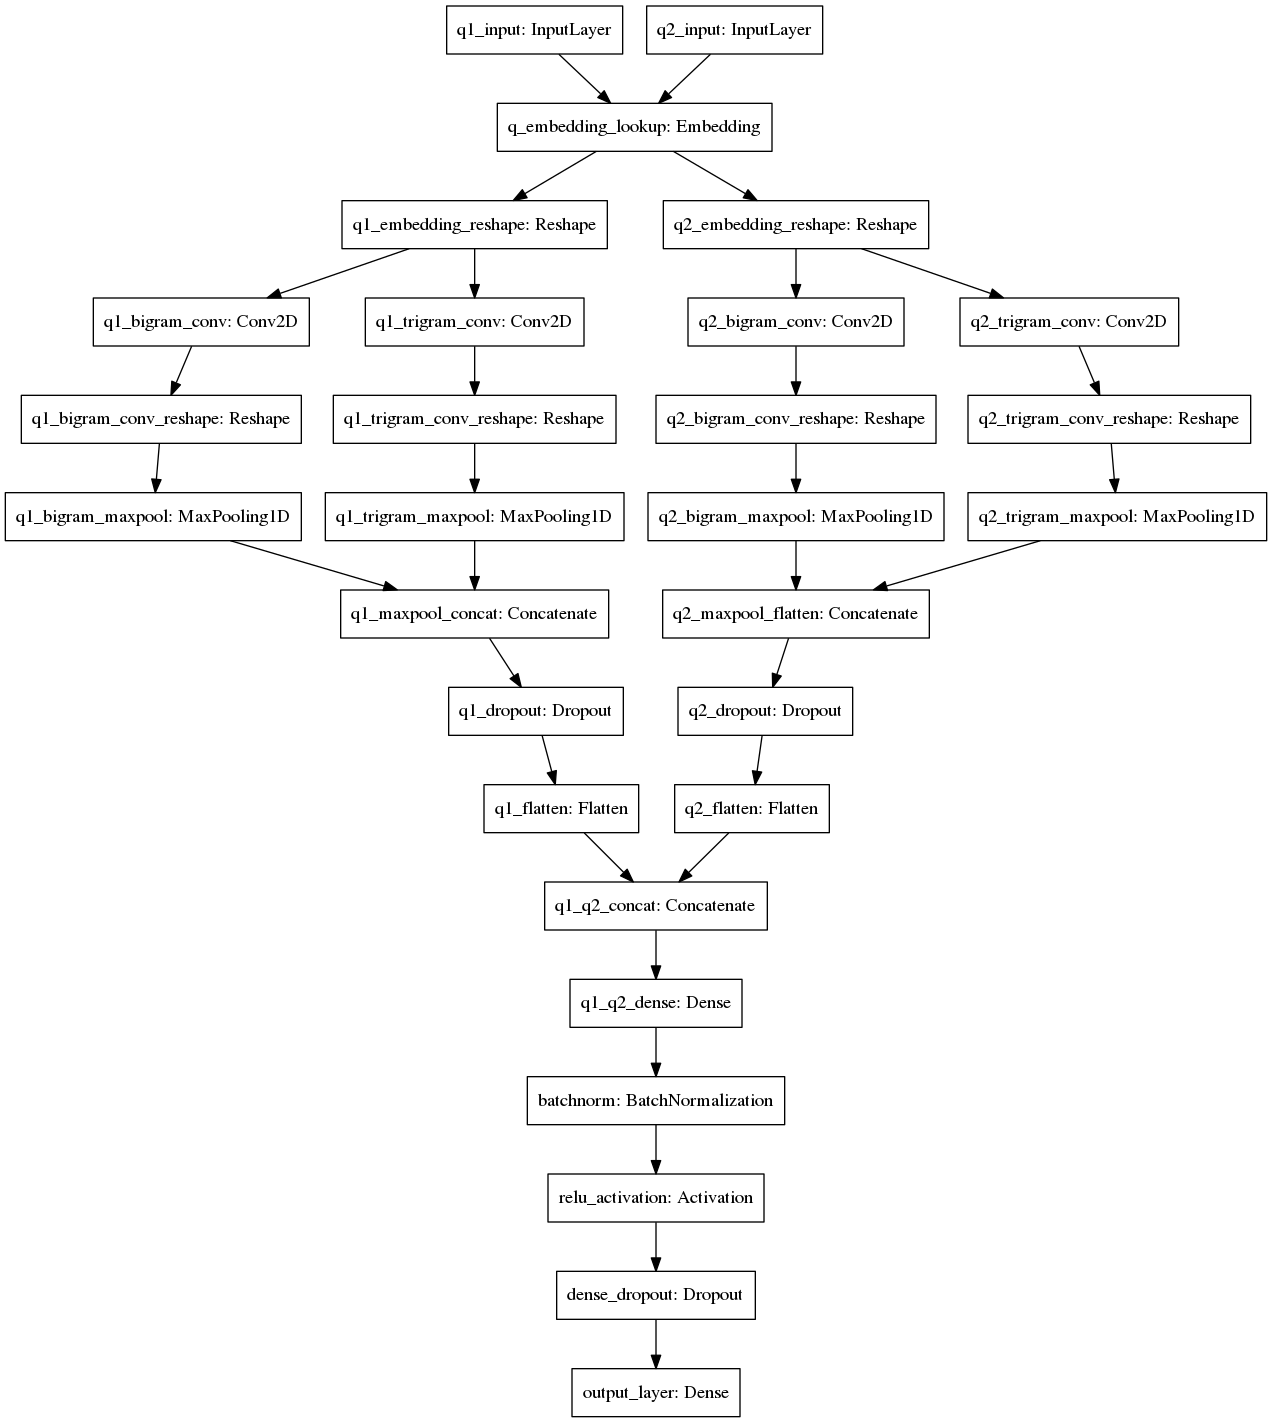

In [25]:
plot_model(model, to_file='text_pair_cnn_classifier.png', show_layer_names=True)
Image('text_pair_cnn_classifier.png')

#### Notes
- This model does not consider interation between sentences
- We could include some attention mechanisms
- CNN Siamese Architectures
- Design and input hand-crafted features along with CNN learnt features at the dense layer

In [ ]:
# This custom layer is required if you want to set mask_zero to be True at the embedding layer
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        # do not pass the mask to the next layers   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def compute_output_shape(self, input_shape):   
        return input_shape
    
emb_1 = NonMasking(name='emb_masking_q1')(emb_1)
emb_2 = NonMasking(name='emb_masking_q2')(emb_2)